# MDETR Model Interpretability with Attribution Guided Factorizatin

## Install Required Libraries (If Needed)

In [1]:
# !pip install timm transformers

In [2]:
import gc # for garbage collection used when CUDA is out of memory
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from hubconf import mdetr_efficientnetB5, mdetr_resnet101
from collections import defaultdict
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches, lines
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore")

from utils import render
from data.imagenet_utils import CLS2IDX

In [3]:
# Check available GPU device.
!nvidia-smi

Fri Dec 17 18:43:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.00       Driver Version: 510.06       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    29W / 370W |   7887MiB / 24576MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preliminaries

### Image Normalization

When read an image into memory, the pixels usually have 8-bit integers between $0$ and $255$ for all three channels. But regression models (including neural networks) prefer floating point values within a smaller range. A typical setup is a mean of $0$ and a standard deviation of $1$ like the standard normal distribution. This transformation for images is called *image normalization*.

For the details about the image normalizations in PyTorch please refer to: <https://sparrow.dev/pytorch-normalize/>.

In [4]:
# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Colors for Visualizations

In [5]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

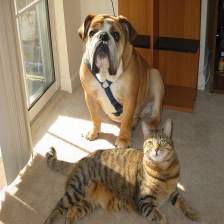

In [6]:
# Read an image from URL.
img_url = "https://github.com/shirgur/AGFVisualization/blob/master/samples/dog-cat.JPEG?raw=true"

# Fetch the image from raw response content.
# Refer to: https://docs.python-requests.org/en/latest/user/quickstart/#raw-response-content
img = Image.open(requests.get(img_url, stream=True).raw)

img


## Import the MDETR Model

In [7]:
# model, postprocessor = mdetr_efficientnetB5(pretrained=True, return_postprocessor=True)

model, postprocessor = mdetr_resnet101(
    pretrained=True, return_postprocessor=True)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
model = model.cuda() # will cause out of memory error on GTX 1650 Ti
# model.eval()

In [9]:
model.AGF()

AGF Modification Applied:)


AttributeError: 'Linear' object has no attribute 'X'

### Helper Functions

In [10]:
def bounding_box_coordmapping(bounding_box):
    x_center, y_center, width, height = bounding_box.unbind(1)
    
    box_coordinates = [
        (x_center - 0.5 * width), (y_center - 0.5 * height),
        (x_center + 0.5 * width), (y_center + 0.5 * height)
    ]
    
    return torch.stack(box_coordinates, dim=1)

def rescale_bounding_boxes(output_bounding_box, size):
    width, height = size # unpack size dimensions
    
    # Apply coordinate mapping for bounding boxes.
    scaled_box = bounding_box_coordmapping(output_bounding_box)
    scaled_box *= torch.Tensor([width, height, width, height])
    
    return scaled_box

def apply_mask(img, mask, color, alpha=0.5):
    for color_channel in range(3):
        img[:, :, color_channel] = np.where(
            mask == 1,
            img[:, :, color_channel] * (1 - alpha) + alpha * color_channel[color] * 255, img[:, :, color_channel])
    
    return img

def plot_results(img, scores, bounding_boxes, labels, masks=None):
    plt.figure(figsize=(5, 5))
    img_np = np.array(img) # convert the PIL image to a numpy array
    ax = plt.gca() # get current axes instance
    colors = COLORS * 100
    
    if masks is None:
        masks = [None for _ in range(len(scores))]
    
    assert len(scores) == len(bounding_boxes) == len(labels) == len(masks)
    
    for score, (x_min, y_min, x_max, y_max), label, mask, color in zip(
        scores, bounding_boxes.tolist(), labels, masks, colors
    ):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=color, linewidth=2))
        text = f'{label}:{score: 0.4f}'
        ax.text(x_min, y_min, text, fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
        
        if mask is None:
            continue
        
        img_np = apply_mask(img_np, mask, color)
        
        mask_padded = np.zeros((mask.shape[0] + 1, mask.shape[1] + 1), dtype=np.uint8)
        mask_padded[1:-1, 1:-1] = mask
        contours = find_contours(mask_padded, 0.5)
        
        for vertex in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            vertex = np.fliplr(vertex) - 1
            polygon = Polygon(vertex, facecolor="none", edgecolor=color)
            ax.add_patch(polygon)
    
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()
    

In [11]:
def plot_inference(img, caption, confidence):
    # Apply mean-std normalization to the input image.
    img_normalized = transform(img).unsqueeze(0).cuda()
    
    # Propagate through the model (forwad path)
    memory_cache = model(img_normalized,
                         [caption],
                         encode_and_save=True)

    outputs = model(img_normalized,
                    [caption],
                    encode_and_save=False,
                    memory_cache=memory_cache)
    
    # Keep only predictions with the given confidence level.
    probabilities = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
    keep = (probabilities > confidence).cpu()
    
    # Convert the bounding boxes from [0; 1] to image scales.
    bounding_boxes_scaled = rescale_bounding_boxes(
        outputs['pred_boxes'].cpu()[0, keep], img.size)
    
    # Extract text spans predicted by each box.
    positive_tokens = (
        outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
    predicted_spans = defaultdict(str)
    
    for token in positive_tokens:
        item, position = token
        
        if position < 255:
            span = memory_cache["tokenized"].token_to_chars(0, position)
            predicted_spans[item] += " " + caption[span.start: span.end]
    labels = [predicted_spans[k] for k in sorted(list(predicted_spans.keys()))]
    
    print(f'Extracted labels from query: {labels}')
    
    plot_results(img, probabilities[keep], bounding_boxes_scaled, labels)


## Detection

In [12]:
# ONLY run this when GPU is out of memory

#del model
#gc.collect()
#torch.cuda.empty_cache()

Extracted labels from query: [' cat', ' dog']


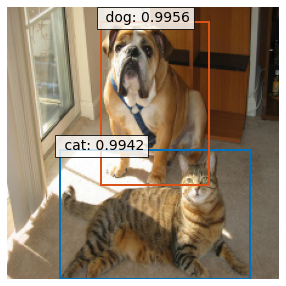

In [13]:
plot_inference(img, "cat and dog", 0.7)

## Model Interpretability Visualization with AGF

In [14]:
def get_visualization(model, mdetr_ouput, **kwargs):
    predictions = mdetr_ouput["pred_logits"]
    probabilities = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    
    # print(class_indices)
    
    max_str_len = 0
    class_names = []
    
    for class_index in class_indices[0]:
        class_name = CLS2IDX[class_index]
        class_names.append(class_name)
        max_str_len = max(max_str_len, len(class_name))
    
    print(class_names)
    
    return model.AGF(**kwargs)

In [15]:
# Apply mean-std normalization to the input image.
img_normalized = transform(img).unsqueeze(0).cuda()

caption = "cat and dog"

# Propagate through the model (forwad path)
memory_cache = model(img_normalized,
                     [caption],
                     encode_and_save=True)

outputs = model(img_normalized,
                [caption],
                encode_and_save=False,
                memory_cache=memory_cache)

dog = get_visualization(model, outputs)


dog = (render.hm_to_rgb(dog[0, 0].data.cpu().numpy(
), scaling=3, sigma=1, cmap='seismic') * 255).astype(np.uint8)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img)
axs[0].axis('off')
axs[1].imshow(dog)
axs[1].axis('off')

['bulbul', 'bulbul', 'bulbul', 'common iguana, iguana, Iguana iguana', 'common iguana, iguana, Iguana iguana', 'common iguana, iguana, Iguana iguana', 'macaw', 'bulbul', 'bulbul', 'bulbul', 'bulbul', 'common iguana, iguana, Iguana iguana', 'common iguana, iguana, Iguana iguana', 'common iguana, iguana, Iguana iguana', 'ptarmigan', 'tree frog, tree-frog', 'tree frog, tree-frog', 'bulbul', 'tench, Tinca tinca', 'bulbul', 'common iguana, iguana, Iguana iguana', 'bulbul', 'common iguana, iguana, Iguana iguana', 'common iguana, iguana, Iguana iguana', 'lorikeet', 'mud turtle', 'common iguana, iguana, Iguana iguana', 'common iguana, iguana, Iguana iguana', 'lorikeet', 'common iguana, iguana, Iguana iguana', 'common iguana, iguana, Iguana iguana', 'bulbul', 'common iguana, iguana, Iguana iguana', 'quail', 'stingray', 'scorpion', 'bulbul', 'bulbul', 'quail', 'electric ray, crampfish, numbfish, torpedo', 'common iguana, iguana, Iguana iguana', 'garden spider, Aranea diademata', 'sea snake', 'ta

RuntimeError: shape '[6, 1, 100, 64]' is invalid for input of size 1280

In [ ]:
for key in outputs.keys():
    print(key)

In [ ]:
outputs['pred_logits'].size()
# numberOfImages    numberOfPotentialObjects/BoundingBoxes      numberOfObjectClasses